In [ ]:
import numpy as np
from typing import Sequence, Optional


class BinaryBTSPNetwork:
    """二值 BTSP 网络（CA3 -> CA1）
    - n_input: CA3 单元数
    - n_memory: CA1 单元数
    - weights: 突触矩阵 (n_memory x n_input)，二值 0/1
    - threshold: 每个 CA1 单元的阈值（向量，长度 n_memory）
    - rng: numpy 随机数生成器，用于可重复性
    """

    def __init__(
        self,
        n_input: int,
        n_memory: int,
        weight_density: float = 0.01,
        seed: Optional[int] = None,
        threshold: Optional[Sequence[int]] = None,
    ) -> None:
        self.n_input = int(n_input)
        self.n_memory = int(n_memory)
        self.rng = np.random.default_rng(seed)

        # 随机初始化二值突触矩阵（按给定密度）
        self.weights = (self.rng.random((self.n_memory, self.n_input)) < float(weight_density)).astype(np.uint8)

        # 默认阈值：每个 CA1 单元输入突触数的一半（向上取整），至少为1
        if threshold is None:
            incoming = self.weights.sum(axis=1)
            thr = np.ceil(incoming / 2).astype(int)
            thr[thr < 1] = 1
            self.threshold = thr
        else:
            thr = np.asarray(threshold)
            if thr.shape == ():
                thr = np.full(self.n_memory, int(thr))
            if thr.shape != (self.n_memory,):
                raise ValueError("threshold must be scalar or length n_memory")
            self.threshold = thr.astype(int)

    def forward(self, input_pattern: Sequence[int]) -> np.ndarray:
        """前向传播（确定性）
        :param input_pattern: 长度为 n_input 的 0/1 数组
        :return: 长度为 n_memory 的 0/1 输出数组
        """
        x = np.asarray(input_pattern, dtype=np.uint8)
        if x.shape != (self.n_input,):
            raise ValueError("input_pattern must have shape (n_input,) or length n_input")
        summed = self.weights.dot(x)  # shape: (n_memory,)
        out = (summed >= self.threshold).astype(np.uint8)
        return out

    def btsp_update(self, input_pattern: Sequence[int]) -> None:
        """执行一次 BTSP 更新（向量化实现，高效）

        规则：仅对 input_pattern 中为 1 的输入列考虑翻转，翻转概率 p=0.5
        向量化实现避免 Python 循环，提高大规模时的性能。
        """
        x = np.asarray(input_pattern, dtype=np.uint8)
        if x.shape != (self.n_input,):
            raise ValueError("input_pattern must have shape (n_input,) or length n_input")

        active_idx = np.nonzero(x)[0]
        if active_idx.size == 0:
            return  # 没有激活的输入，不做更新

        # 为每个被激活的输入列生成 n_memory 大小的布尔翻转掩码
        flips = self.rng.random((self.n_memory, active_idx.size)) < 0.5  # True 表示翻转

        # 将布尔数组与对应的权重列进行异或（翻转）
        # 注意：weights 子矩阵是 uint8，flips 是布尔，需要先转换
        sub = self.weights[:, active_idx]
        # XOR: 1 ^ 1 = 0, 0 ^ 1 = 1
        self.weights[:, active_idx] = np.bitwise_xor(sub, flips.astype(np.uint8))

    def train(self, patterns: Sequence[Sequence[int]]) -> None:
        """对一系列输入模式训练，每个模式只展示一次"""
        for pat in patterns:
            self.btsp_update(pat)

    # -------------------- 辅助函数 --------------------

    def make_sparse_patterns(n_patterns: int, n_input: int, sparsity: float, rng: np.random.Generator) -> np.ndarray:
        """生成稀疏二值输入模式矩阵，返回 shape=(n_patterns, n_input) 的 uint8 数组"""
        if not (0.0 < sparsity <= 1.0):
            raise ValueError("sparsity must be in (0, 1]")
        return (rng.random((n_patterns, n_input)) < float(sparsity)).astype(np.uint8)

In [20]:





# ================================
# 示例：训练并测试网络
# ================================
if __name__ == "__main__":
    np.random.seed(42)  # 保证复现性

    # 定义输入和记忆神经元规模
    n_input = 2000
    n_memory = 3000

    # 初始化网络
    net = BinaryBTSPNetwork(n_input, n_memory)

    # 构造 3 个随机输入模式
    patterns = (np.random.rand(30, n_input) < 0.01).astype(int)

    # 训练网络
    print("开始训练 ...")
    net.train(patterns)
    print("训练完成。\n")

    # 训练后用相同输入测试
    print("训练后测试结果：")
    for i, pattern in enumerate(patterns):
        output = net.forward(pattern)
        print(f"模式 {i+1}: 激活的 CA1 数量 = {np.sum(output)}")
        print(f"模式 {i+1}: 激活索引（前10个）= {np.where(output==1)[0][:10]}\n")



开始训练 ...
训练完成。

训练后测试结果：
模式 1: 激活的 CA1 数量 = 400
模式 1: 激活索引（前10个）= [ 0  8 20 23 26 27 29 39 40 41]

模式 2: 激活的 CA1 数量 = 1954
模式 2: 激活索引（前10个）= [ 0  1  3  4  5  6  8 10 11 12]

模式 3: 激活的 CA1 数量 = 1041
模式 3: 激活索引（前10个）= [ 3  5  9 10 13 19 23 26 27 29]

模式 4: 激活的 CA1 数量 = 1958
模式 4: 激活索引（前10个）= [ 0  3  7 10 11 12 13 14 16 17]

模式 5: 激活的 CA1 数量 = 1799
模式 5: 激活索引（前10个）= [ 0  2  3  4  6  7  8  9 10 11]

模式 6: 激活的 CA1 数量 = 2245
模式 6: 激活索引（前10个）= [ 0  3  4  5  6  7  8  9 10 11]

模式 7: 激活的 CA1 数量 = 1596
模式 7: 激活索引（前10个）= [ 0  3  4  8 10 11 14 15 17 19]

模式 8: 激活的 CA1 数量 = 1211
模式 8: 激活索引（前10个）= [ 3  8 10 11 14 17 20 21 26 27]

模式 9: 激活的 CA1 数量 = 1762
模式 9: 激活索引（前10个）= [ 0  3  4  6  7  8  9 10 11 14]

模式 10: 激活的 CA1 数量 = 1055
模式 10: 激活索引（前10个）= [ 0  3  6  8 10 16 19 20 23 26]

模式 11: 激活的 CA1 数量 = 835
模式 11: 激活索引（前10个）= [ 3  4  8 10 20 22 26 27 35 36]

模式 12: 激活的 CA1 数量 = 1631
模式 12: 激活索引（前10个）= [ 0  3 10 14 15 16 17 18 20 21]

模式 13: 激活的 CA1 数量 = 1623
模式 13: 激活索引（前10个）= [ 3  4  5  8  9 10 11 13 14

In [21]:
# ================================
# 示例：训练后掩码测试
# ================================
mask_ratio = 0.1  # 掩盖 10% 的输入
print("训练后掩码测试：")
for i, pattern in enumerate(patterns):
    # 原始输出
    ca1_original = net.forward(pattern)

    # 构造掩码
    mask = np.ones_like(pattern, dtype=np.uint8)
    n_mask = int(mask_ratio * len(pattern))
    mask_indices = np.random.choice(len(pattern), size=n_mask, replace=False)
    mask[mask_indices] = 0

    # 应用掩码
    masked_input = pattern * mask

    # 前向传播
    ca1_masked = net.forward(masked_input)

    # 比较输出差异
    n_diff = np.sum(ca1_original != ca1_masked)
    identical = n_diff == 0

    print(f"模式 {i+1}: 输出是否完全一致? {identical}, 不同神经元数量 = {n_diff}")
    print(f"原始激活数量 = {np.sum(ca1_original)}, 掩码后激活数量 = {np.sum(ca1_masked)}\n")


训练后掩码测试：
模式 1: 输出是否完全一致? False, 不同神经元数量 = 227
原始激活数量 = 400, 掩码后激活数量 = 173

模式 2: 输出是否完全一致? False, 不同神经元数量 = 375
原始激活数量 = 1954, 掩码后激活数量 = 1579

模式 3: 输出是否完全一致? False, 不同神经元数量 = 545
原始激活数量 = 1041, 掩码后激活数量 = 496

模式 4: 输出是否完全一致? False, 不同神经元数量 = 345
原始激活数量 = 1958, 掩码后激活数量 = 1613

模式 5: 输出是否完全一致? False, 不同神经元数量 = 782
原始激活数量 = 1799, 掩码后激活数量 = 1017

模式 6: 输出是否完全一致? False, 不同神经元数量 = 309
原始激活数量 = 2245, 掩码后激活数量 = 1936

模式 7: 输出是否完全一致? False, 不同神经元数量 = 740
原始激活数量 = 1596, 掩码后激活数量 = 856

模式 8: 输出是否完全一致? False, 不同神经元数量 = 200
原始激活数量 = 1211, 掩码后激活数量 = 1011

模式 9: 输出是否完全一致? False, 不同神经元数量 = 160
原始激活数量 = 1762, 掩码后激活数量 = 1602

模式 10: 输出是否完全一致? False, 不同神经元数量 = 661
原始激活数量 = 1055, 掩码后激活数量 = 394

模式 11: 输出是否完全一致? False, 不同神经元数量 = 472
原始激活数量 = 835, 掩码后激活数量 = 363

模式 12: 输出是否完全一致? False, 不同神经元数量 = 579
原始激活数量 = 1631, 掩码后激活数量 = 1052

模式 13: 输出是否完全一致? False, 不同神经元数量 = 377
原始激活数量 = 1623, 掩码后激活数量 = 1246

模式 14: 输出是否完全一致? False, 不同神经元数量 = 149
原始激活数量 = 673, 掩码后激活数量 = 524

模式 15: 输出是否完全一致? False, 不同神经元数量 = 478
原始激活数

掩码比例 0%: 平均记忆回想相同位比例 = 1.0000
掩码比例 5%: 平均记忆回想相同位比例 = 0.9467
掩码比例 10%: 平均记忆回想相同位比例 = 0.8943
掩码比例 15%: 平均记忆回想相同位比例 = 0.8365
掩码比例 20%: 平均记忆回想相同位比例 = 0.7825
掩码比例 25%: 平均记忆回想相同位比例 = 0.7319
掩码比例 30%: 平均记忆回想相同位比例 = 0.6867
掩码比例 35%: 平均记忆回想相同位比例 = 0.6428
掩码比例 40%: 平均记忆回想相同位比例 = 0.6029
掩码比例 45%: 平均记忆回想相同位比例 = 0.5789
掩码比例 50%: 平均记忆回想相同位比例 = 0.5481
掩码比例 55%: 平均记忆回想相同位比例 = 0.5232
掩码比例 60%: 平均记忆回想相同位比例 = 0.5117
掩码比例 65%: 平均记忆回想相同位比例 = 0.4986
掩码比例 70%: 平均记忆回想相同位比例 = 0.4918
掩码比例 75%: 平均记忆回想相同位比例 = 0.4873
掩码比例 80%: 平均记忆回想相同位比例 = 0.4852
掩码比例 85%: 平均记忆回想相同位比例 = 0.4843
掩码比例 90%: 平均记忆回想相同位比例 = 0.4840
掩码比例 95%: 平均记忆回想相同位比例 = 0.4839


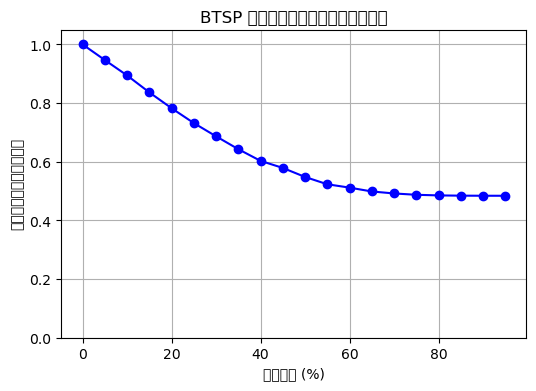

In [22]:
import matplotlib.pyplot as plt

# ================================
# 绘制掩码比例 vs 平均记忆回想相同位比例
# ================================
mask_ratios = np.arange(0, 1.0, 0.05)
n_repeats = 20
mean_overlaps = []

for mask_ratio in mask_ratios:
    overlaps = []
    for _ in range(n_repeats):
        for pattern in patterns:
            ca1_original = net.forward(pattern)

            # 构造掩码
            mask = np.ones_like(pattern, dtype=np.uint8)
            n_mask = int(mask_ratio * len(pattern))
            if n_mask > 0:
                mask_indices = np.random.choice(len(pattern), size=n_mask, replace=False)
                mask[mask_indices] = 0

            masked_input = pattern * mask
            ca1_masked = net.forward(masked_input)

            # 计算相同位比例
            overlap_ratio = np.sum(ca1_original == ca1_masked) / len(ca1_original)
            overlaps.append(overlap_ratio)

    mean_overlap = np.mean(overlaps)
    mean_overlaps.append(mean_overlap)
    print(f"掩码比例 {mask_ratio*100:.0f}%: 平均记忆回想相同位比例 = {mean_overlap:.4f}")

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(mask_ratios*100, mean_overlaps, marker='o', linestyle='-', color='b')
plt.xlabel("掩码比例 (%)")
plt.ylabel("平均记忆回想相同位比例")
plt.title("BTSP 网络记忆鲁棒性随掩码比例变化")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()
